In [14]:
import gradio as gr
from openai import OpenAI
import os
from dotenv import load_dotenv
from llama_parse import LlamaParse

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain.schema import Document
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage

# 환경변수 로드
load_dotenv()

True

In [15]:
# LLM 모델 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# --- Document Loading and Caching ---
PDF_PATH = "data/gemini-2.5-tech_3.pdf"
PARSED_MD_PATH = "loaddata/llamaparse_output_gemini_3.md"
CHROMA_DB_DIR = "./chroma_db2"

In [16]:
# 1. Splitters
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=300)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)

# 2. Embeddings
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# 3. Vectorstore
vectorstore = Chroma(persist_directory=CHROMA_DB_DIR, embedding_function=embeddings)

# 4. ParentDocumentRetriever
store = InMemoryStore()
retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
    search_kwargs={"k":2}
)


In [17]:
def load_and_populate_vectorstore():
    if vectorstore._collection.count() > 0:
        return
    if not os.path.exists(PARSED_MD_PATH):
        parser = LlamaParse(result_type="markdown", api_key=os.getenv("LLAMA_CLOUD_API_KEY"))
        documents = parser.load_data(PDF_PATH)
        with open(PARSED_MD_PATH, "w", encoding="utf-8") as f:
            f.write("\n".join([doc.text for doc in documents]))
    with open(PARSED_MD_PATH, "r", encoding="utf-8") as f:
        text = f.read()
    retriever.add_documents([Document(page_content=text)])


In [18]:
# 1. Prompt for History-Aware Retriever
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
    ]
)

history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


In [19]:
# 2. Create the History-Aware Retriever
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

In [20]:
# 3. Prompt for Final Answer Generation
ga_system_prompt = (
    "You are a helpful assistant. Your ONLY task is to answer the user's question STRICTLY based on the provided context. "
    "If the information to answer the question is present in the context, provide a concise answer. "
    "If the answer cannot be found within the provided context, you MUST say '제공된 문서의 내용으로는 답변할 수 없습니다.' Do NOT use any of your outside knowledge."
    "\n\nContext:\n{context}"
)
ga_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", ga_system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, ga_prompt)


In [21]:
# 4. Create the Document Chain
question_answer_chain = create_stuff_documents_chain(llm, ga_prompt)

# --- RAG Function ---
def ask_llm(query, history):
    chat_history_for_chain = []
    if history:
        for message in history:
            if message["role"] == "user":
                chat_history_for_chain.append(HumanMessage(content=message["content"]))
            elif message["role"] == "assistant":
                chat_history_for_chain.append(AIMessage(content=message["content"]))

In [25]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [24]:
### Retrieval Grader

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

c:\Users\SBA\miniconda3\envs\mp\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\SBA\miniconda3\envs\mp\Lib\site-packages\langchain_openai\chat_models\base.py:1914: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="f

In [26]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")
# prompt = hub.pull("teddynote/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

In [27]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
question = "agent memory"

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'What is agent memory and how does it function in artificial intelligence?'

In [22]:
from langgraph.graph import END, StateGraph, START
from typing_extensions import TypedDict
from typing import List

# --- GraphState 정의 ---
class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[str]
    chat_history: list

# --- Node 함수들 ---
def retrieve(state):
    print("---RETRIEVE---")
    question = state["question"]
    chat_history = state.get("chat_history", [])

    # history-aware retriever 사용
    retrieved_docs = history_aware_retriever.invoke({
        "input": question,
        "chat_history": chat_history
    })
    return {"documents": retrieved_docs, "question": question, "chat_history": chat_history}

def grade_documents(state):
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        if score.binary_score == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search, "chat_history": state["chat_history"]}

def generate(state):
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    chat_history = state["chat_history"]

    answer = question_answer_chain.invoke({
        "input": question,
        "chat_history": chat_history,
        "context": documents
    })
    return {"documents": documents, "question": question, "generation": answer, "chat_history": chat_history}

def transform_query(state):
    print("---TRANSFORM QUERY---")
    question = state["question"]
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": state["documents"], "question": better_question, "chat_history": state["chat_history"]}

def web_search_node(state):
    print("---WEB SEARCH---")
    question = state["question"]
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    documents = state["documents"]
    documents.append(Document(page_content=web_results))
    return {"documents": documents, "question": question, "chat_history": state["chat_history"]}

def decide_to_generate(state):
    if state["web_search"] == "Yes":
        return "transform_query"
    else:
        return "generate"

# --- 그래프 구성 ---
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search_node)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {"transform_query": "transform_query", "generate": "generate"}
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()


In [23]:
inputs = {"question": "Gemini 2.5 Pro는 무엇이 달라졌나요?", "chat_history": []}
for output in app.stream(inputs):
    print(output)


---RETRIEVE---
{'retrieve': {'documents': [], 'question': 'Gemini 2.5 Pro는 무엇이 달라졌나요?', 'chat_history': []}}
---CHECK DOCUMENT RELEVANCE TO QUESTION---
{'grade_documents': {'documents': [], 'question': 'Gemini 2.5 Pro는 무엇이 달라졌나요?', 'web_search': 'No', 'chat_history': []}}
---GENERATE---
{'generate': {'documents': [], 'question': 'Gemini 2.5 Pro는 무엇이 달라졌나요?', 'generation': '제공된 문서의 내용으로는 답변할 수 없습니다.', 'chat_history': []}}


In [32]:
# !pip install langchain_community
from langchain_community.tools.tavily_search import TavilySearchResults

In [33]:
# ================================================================
# PDF Conversational RAG + CRAG(Conditional RAG) 통합 버전 (Gradio UI)
# - PDF → LlamaParse(md) → Chroma(Parent/Child) → History-Aware Retrieve
# - CRAG: grade_documents → (generate | transform_query → web_search → generate)
# - 문서 외 지식 금지, 없으면 한국어로 "제공된 문서..." 출력
# - 웹검색: Tavily(선택, 미설정 시 우회)
# ================================================================

import os
import json
import traceback
import gradio as gr
from dotenv import load_dotenv

# Python typing
from typing import Iterable, Optional, Tuple, List
from typing_extensions import TypedDict

# PDF Parser
from llama_parse import LlamaParse

# LangChain Core / OpenAI / Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
from langchain.retrievers import ParentDocumentRetriever
from langchain.schema import Document
from langchain.chains import create_history_aware_retriever
from langchain.chains.combine_documents import create_stuff_documents_chain

# LangChain Core (Prompts, Messages, Output parsing)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.stores import BaseStore  # ✅ BaseStore는 여기로 이동됨

# LangGraph
from langgraph.graph import END, START, StateGraph

# Pydantic (v2)
from pydantic import BaseModel, Field

# (Optional) 웹 검색 툴
from langchain_tavily import TavilySearch


# --- Add: Persistent JSON-backed DocStore for parents ---


class JSONDocStore(BaseStore[str, Document]):
    """
    간단한 파일 기반 영구 DocStore.
    - key -> ./parent_store/{key}.json 에 Document 저장
    - ParentDocumentRetriever 가 요구하는 mset/mget/mdelete/yield_keys 구현
    """
    def __init__(self, root_dir: str = "./parent_store"):
        self.root_dir = root_dir
        os.makedirs(self.root_dir, exist_ok=True)

    def _path(self, key: str) -> str:
        return os.path.join(self.root_dir, f"{key}.json")

    def mset(self, key_value_pairs: Iterable[Tuple[str, Document]]) -> None:
        for key, doc in key_value_pairs:
            with open(self._path(key), "w", encoding="utf-8") as f:
                json.dump(
                    {"page_content": doc.page_content, "metadata": doc.metadata},
                    f,
                    ensure_ascii=False,
                )

    def mget(self, keys: Iterable[str]) -> List[Optional[Document]]:
        results: List[Optional[Document]] = []
        for key in keys:
            p = self._path(key)
            if os.path.exists(p):
                with open(p, "r", encoding="utf-8") as f:
                    data = json.load(f)
                results.append(
                    Document(
                        page_content=data.get("page_content", ""),
                        metadata=data.get("metadata", {}),
                    )
                )
            else:
                results.append(None)
        return results

    def mdelete(self, keys: Iterable[str]) -> None:
        for key in keys:
            p = self._path(key)
            if os.path.exists(p):
                os.remove(p)

    def yield_keys(self, prefix: Optional[str] = None) -> Iterable[str]:
        for fname in os.listdir(self.root_dir):
            if not fname.endswith(".json"):
                continue
            key = fname[:-5]  # strip .json
            if prefix is None or key.startswith(prefix):
                yield key


# --------------------------
# 환경변수 로드 & 설정
# --------------------------
load_dotenv()
OPENAI_KEY = os.getenv("OPENAI_API_KEY")
LLAMA_KEY = os.getenv("LLAMA_CLOUD_API_KEY")
TAVILY_KEY = os.getenv("TAVILY_API_KEY")  # 없으면 웹검색 보강은 건너뜀

# --------------------------
# 경로 및 전역 설정
# --------------------------
PDF_PATH = "data/gemini-2.5-tech_1-10.pdf"
PARSED_MD_PATH = "loaddata/llamaparse_output_gemini_1-10.md"
CHROMA_DB_DIR = "./chroma_db10"

# --------------------------
# LLM & 임베딩
# --------------------------
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# --------------------------
# Text Splitters
# --------------------------
parent_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=300)
child_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=30)

# --------------------------
# Vector Store (Chroma)
# --------------------------
vectorstore = Chroma(persist_directory=CHROMA_DB_DIR, embedding_function=embeddings)

# --------------------------
# ParentDocumentRetriever
# --------------------------
# 기존: store = InMemoryStore()
store = JSONDocStore("./parent_store")  # 파일 기반 parent 저장

retriever = ParentDocumentRetriever(
    vectorstore=vectorstore,
    docstore=store,
    child_splitter=child_splitter,
    parent_splitter=parent_splitter,
    search_kwargs={"k": 2},
)


# --------------------------
# 데이터 로딩 & 벡터DB 적재
# --------------------------
def _vs_count_safe() -> int:
    # 내부 속성 의존을 최소화하는 안전한 카운트 함수
    try:
        return vectorstore._collection.count()  # chroma 내부
    except Exception:
        try:
            # 간단히 비슷문서 조회 시도 (비어있으면 예외 or 빈 결과)
            _ = vectorstore.similarity_search("dummy", k=1)
            # Chroma는 비어있어도 호출이 성공할 수 있으므로 peek 써봄
            return len(vectorstore._collection.peek()["ids"])  # type: ignore
        except Exception:
            return 0

def load_and_populate_vectorstore():
    os.makedirs(os.path.dirname(PARSED_MD_PATH), exist_ok=True)
    os.makedirs(CHROMA_DB_DIR, exist_ok=True)

    if _vs_count_safe() > 0:
        print(f"[INFO] Vector store already populated. Count={_vs_count_safe()}")
        return

    # MD 파일 없으면 PDF → LlamaParse → md 저장
    if not os.path.exists(PARSED_MD_PATH):
        print(f"[INFO] '{PARSED_MD_PATH}' not found. Parsing PDF with LlamaParse...")
        if not LLAMA_KEY:
            raise RuntimeError("LLAMA_CLOUD_API_KEY가 없어 PDF 파싱을 수행할 수 없습니다.")
        try:
            parser = LlamaParse(result_type="markdown", api_key=LLAMA_KEY)
            documents = parser.load_data(PDF_PATH)
            md_text = "\n".join([doc.text for doc in documents])
            with open(PARSED_MD_PATH, "w", encoding="utf-8") as f:
                f.write(md_text)
            print(f"[INFO] Parsed & saved to '{PARSED_MD_PATH}'")
        except Exception as e:
            raise RuntimeError(f"LlamaParse 오류: {e}")

    # md 로드 → Parent retriever에 추가
    print(f"[INFO] Loading markdown from '{PARSED_MD_PATH}'...")
    with open(PARSED_MD_PATH, "r", encoding="utf-8") as f:
        text = f.read()

    # 하나의 거대 문서로 추가 → Parent/Child splitter가 내부에서 잘게 쪼갬
    documents = [Document(page_content=text, metadata={"source": PARSED_MD_PATH})]
    retriever.add_documents(documents)
    print(f"[INFO] Vector store populated. Count={_vs_count_safe()}")


# --------------------------
# History-Aware Retriever
# --------------------------
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question which might reference context in the chat history, "
    "formulate a standalone question which can be understood without the chat history. "
    "Do NOT answer the question, just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(llm, retriever, contextualize_q_prompt)

# --------------------------
# 최종 답변(문서 기반만 허용) Chain
# --------------------------
ga_system_prompt = (
    "You are a helpful assistant. Your task is to answer the user's question based on the provided context. "
    "The context may come from PDF documents or from web search results. "
    "If useful information is present in the context (including web search), provide a concise answer. "
    "If the answer cannot be found within the provided context, you MUST say '제공된 문서나 검색 결과의 내용으로는 답변할 수 없습니다.' "
    "\n\nContext:\n{context}"
)

ga_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", ga_system_prompt),
        MessagesPlaceholder(variable_name="chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, ga_prompt)

# --------------------------
# CRAG: 문서 관련성 평가(Structured Output)
# --------------------------
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

grade_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question.
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
Return 'yes' or 'no'."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grade_system_prompt),
        ("human", "Retrieved document:\n\n{document}\n\nUser question: {question}"),
    ]
)
structured_llm_grader = llm.with_structured_output(GradeDocuments)
retrieval_grader = grade_prompt | structured_llm_grader

# --------------------------
# CRAG: 질문 재작성 (웹검색 친화적)
# --------------------------
rewrite_system = (
    "You are a question re-writer that converts an input question to a better version optimized for web search. "
    "Reason about the underlying semantic intent and produce a clearer query."
)
rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rewrite_system),
        ("human", "Here is the initial question:\n\n{question}\n\nFormulate an improved question."),
    ]
)
question_rewriter = rewrite_prompt | llm | StrOutputParser()

# --------------------------
# (선택) 웹검색 도구
# --------------------------
web_search_tool: Optional[TavilySearch] = None
if TAVILY_KEY:
    web_search_tool = TavilySearch(k=3)
else:
    print("[WARN] TAVILY_API_KEY 미설정: 웹검색 보강은 생략됩니다.")


# --------------------------
# LangGraph 상태 정의
# --------------------------
class GraphState(TypedDict):
    question: str
    generation: str
    web_search: str
    documents: List[Document]
    chat_history: List  # HumanMessage/AIMessage 리스트


# --------------------------
# LangGraph 노드 함수
# --------------------------
def node_retrieve(state: GraphState) -> GraphState:
    print("---RETRIEVE---")
    question = state["question"]
    chat_history = state.get("chat_history", [])
    docs = history_aware_retriever.invoke({"input": question, "chat_history": chat_history})
    return {"documents": docs, "question": question, "chat_history": chat_history, "web_search": "No", "generation": ""}

def node_grade_documents(state: GraphState) -> GraphState:
    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    filtered_docs: List[Document] = []
    for d in documents:
        try:
            score = retrieval_grader.invoke({"question": question, "document": d.page_content})
            if score.binary_score.strip().lower() == "yes":
                print("---GRADE: DOCUMENT RELEVANT---")
                filtered_docs.append(d)
            else:
                print("---GRADE: DOCUMENT NOT RELEVANT---")
        except Exception:
            # 그레이더 실패 시 일단 보수적으로 유지
            filtered_docs.append(d)

    web_search_flag = "Yes" if len(filtered_docs) == 0 else "No"
    return {
        "documents": filtered_docs,
        "question": question,
        "web_search": web_search_flag,
        "chat_history": state["chat_history"],
        "generation": state.get("generation", ""),
    }

def node_decide_to_generate(state: GraphState) -> str:
    print("---ASSESS GRADED DOCUMENTS---")
    return "transform_query" if state["web_search"] == "Yes" else "generate"

def node_transform_query(state: GraphState) -> GraphState:
    print("---TRANSFORM QUERY---")
    better_question = question_rewriter.invoke({"question": state["question"]})
    return {
        "documents": state["documents"],
        "question": better_question,
        "web_search": state["web_search"],
        "chat_history": state["chat_history"],
        "generation": state.get("generation", ""),
    }

def node_web_search(state: GraphState) -> GraphState:
    print("---WEB SEARCH---")
    documents = state["documents"]
    question = state["question"]

    if web_search_tool is None:
        # 웹검색 불가 시 안내 문서 추가
        web_results_text = "웹검색 API 키가 설정되지 않아 웹검색을 수행하지 못했습니다."
    else:
        try:
            results = web_search_tool.invoke({"query": question})
            lines = []
            for r in results:
                # r keys: content, url, score, title 등
                title = r.get("title") or ""
                url = r.get("url") or ""
                content = r.get("content") or ""
                lines.append(f"[{title}] {url}\n{content}\n")
            web_results_text = "\n---\n".join(lines) if lines else "검색결과가 비어 있습니다."
        except Exception as e:
            web_results_text = f"웹검색 중 오류: {e}"

    documents = documents + [Document(page_content=web_results_text, metadata={"source": "tavily"})]
    return {
        "documents": documents,
        "question": question,
        "web_search": "No",
        "chat_history": state["chat_history"],
        "generation": state.get("generation", ""),
    }

def node_generate(state: GraphState) -> GraphState:
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    chat_history = state["chat_history"]

    # 답변 생성
    answer = question_answer_chain.invoke({
        "input": question,
        "chat_history": chat_history,
        "context": documents
    })

    # 출처 구분
    if any(d.metadata.get("source") == "tavily" for d in documents):
        source_tag = "\n\n[출처: 웹검색 결과]"
    else:
        source_tag = "\n\n[출처: PDF 문서]"

    return {
        "documents": documents,
        "question": question,
        "web_search": "No",
        "chat_history": chat_history,
        "generation": (answer if isinstance(answer, str) else str(answer)) + source_tag,
    }


# --------------------------
# 그래프 구성 & 컴파일
# --------------------------
workflow = StateGraph(GraphState)
workflow.add_node("retrieve", node_retrieve)
workflow.add_node("grade_documents", node_grade_documents)
workflow.add_node("generate", node_generate)
workflow.add_node("transform_query", node_transform_query)
workflow.add_node("web_search_node", node_web_search)

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    node_decide_to_generate,
    {"transform_query": "transform_query", "generate": "generate"},
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

app = workflow.compile()


# --------------------------
# 유틸: Gradio용 히스토리 변환
# --------------------------
def to_lc_messages(history: List[dict]) -> List:
    msgs = []
    for m in history:
        if m["role"] == "user":
            msgs.append(HumanMessage(content=m["content"]))
        elif m["role"] == "assistant":
            msgs.append(AIMessage(content=m["content"]))
    return msgs


# --------------------------
# Gradio 핸들러
# --------------------------
def run_crag(query: str, history: List[dict]):
    # 1) Chat history 변환
    chat_history_for_chain = to_lc_messages(history or [])

    # 2) 그래프 실행
    try:
        final_state = None
        inputs = {"question": query, "chat_history": chat_history_for_chain, "documents": [], "web_search": "No", "generation": ""}
        for step in app.stream(inputs):
            # 디버깅 로그(선택)
            for node_name, node_state in step.items():
                print(f"[TRACE] Node '{node_name}' passed.")
            final_state = node_state  # 마지막 state

        # 3) 최종 응답/문서 정리
        answer = final_state.get("generation", "제공된 문서의 내용으로는 답변할 수 없습니다.")
        docs: List[Document] = final_state.get("documents", [])
        context_md = "## 참조 문서\n\n"
        if docs:
            for i, d in enumerate(docs, 1):
                src = d.metadata.get("source", "N/A")
                snippet = d.page_content[:800] + ("..." if len(d.page_content) > 800 else "")
                context_md += f"### 문서 {i} (source: {src})\n```\n{snippet}\n```\n\n"
        else:
            context_md += "참조된 문서가 없습니다."

        # 4) 히스토리에 추가
        if history is None:
            history = []
        history.append({"role": "user", "content": query})
        history.append({"role": "assistant", "content": answer})

        return "", history, context_md

    except Exception as e:
        err = f"오류 발생: {e}\n{traceback.format_exc()}"
        if history is None:
            history = []
        history.append({"role": "user", "content": query})
        history.append({"role": "assistant", "content": "오류가 발생했습니다. 콘솔 로그를 확인하세요."})
        return "", history, f"### 오류\n```\n{err}\n```"


def force_reload_vectorstore():
    try:
        print("[INFO] Resetting Chroma client...")
        vectorstore._client.reset()  # 전체 컬렉션 초기화
        load_and_populate_vectorstore()
        return "✅ Vector store reloaded successfully!"
    except Exception as e:
        return f"❌ Error during vector store reload: {e}"


# --------------------------
# 초기 적재
# --------------------------
load_and_populate_vectorstore()

# --------------------------
# Gradio UI
# --------------------------
example_questions = [
    "Gemini 2.5 Pro는 Gemini 1.5 Pro와 비교했을 때 어떤 점에서 향상되었나요?",
    "Gemini 2.5 Pro와 Flash는 어떤 종류의 데이터를 처리할 수 있나요?",
    "Gemini 2.5 시리즈의 작은 모델들은 어떤 방식으로 성능을 개선했나요?",
]

with gr.Blocks(theme="soft", title="PDF RAG + CRAG Chatbot") as demo:
    gr.Markdown("# PDF RAG + CRAG Chatbot (LlamaParse / ParentRetriever / History-Aware / Web Search)")
    gr.Markdown("PDF 문서 내용에 대해 질문하세요. 문서에서 못 찾으면 질문 재작성 + (선택)웹검색으로 보강합니다.")

    with gr.Row():
        with gr.Column(scale=2):
            chatbot = gr.Chatbot(height=420, label="Chat", type="messages", value=[])
            msg = gr.Textbox(label="질문을 입력하세요... (Shift+Enter 줄바꿈)")

            gr.Examples(examples=example_questions, inputs=msg, label="예시 질문")

        with gr.Column(scale=1):
            context_display = gr.Markdown(label="LLM 참조 문서 전문/요약")
            with gr.Accordion("⚙️ Advanced Options", open=False):
                reload_button = gr.Button("🔄 Force Reload Vector Store")
                reload_status = gr.Markdown()

    clear = gr.ClearButton([msg, chatbot, context_display])
    msg.submit(run_crag, [msg, chatbot], [msg, chatbot, context_display])
    reload_button.click(force_reload_vectorstore, outputs=reload_status)

# demo.launch()


[INFO] Vector store already populated. Count=174


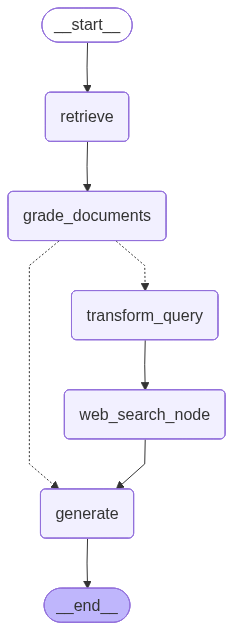

In [34]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass